In [192]:
from instruction_reader import InstructionReader
from parse import parse_sexprs
import random

import tensorflow.compat.v1 as tf
import os
import pdb
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from tf_optimizer import TfOptimizer
from parse import parse_sexprs
from instruction_reader import InstructionReader


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)
tf.disable_v2_behavior()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import argparse
import pdb

from builder import build
from util import DEFAULTS
import copy

In [193]:
def generate_next_line(reader: InstructionReader=None):
    # # randomly select one line
    # first_word = select_first_word(reader)
    # third_word = select_third_word(reader, first_word)
    # obj_name = select_second_word(reader, third_word)

    first_word = 'param'
    obj_name = 'A'
    third_word = 'point'
    line = "".join(['(', first_word, ' ', obj_name, ' ', third_word, ')'])
    
    return line

In [194]:
random.sample(reader.points, 2)

[<primitives.Point at 0x21f1a6ce100>, <primitives.Point at 0x21f1c8603d0>]

In [225]:
lines = [
    '(param (A B C D) polygon)',
    '(param C1 circle)',
    '(define L1 line (reflect-ll (line C D) (line A B)))',
    '(param F point (in-poly A B C D))',
    '(param G point (on-line L1))',
    '(define H point (inter-lc L1 C1 (rs-closer-to-p A)))',
    ]
reader = InstructionReader(lines)

In [196]:
[reader.points,
 reader.lines,
 reader.circles,
 reader.instructions,
 reader.problem_lines]

[[<primitives.Point at 0x21f19c5a850>,
 ['(param (A B C D) polygon)',
  '(param C1 circle)',
  '(define L1 line (reflect-ll (line C D) (line A B)))',
  '(param F point (in-poly A B C D))',
  '(param G point (on-line L1))',
  '(define H point (inter-lc L1 C1 (rs-closer-to-p A)))']]

In [197]:
def add_new_line(prev_reader: InstructionReader, line: str):
    # try creating the first object
    if prev_reader is None:
        try:
            new_reader = InstructionReader([line])
            return [True, new_reader]
        except:
            return [False, prev_reader]

    # try adding the new line
    new_reader = copy.copy(prev_reader)
    cmd = parse_sexprs([line])[0]
    line_is_feasible = new_reader.add_cmd(cmd)

    if line_is_feasible:
        return [True, new_reader]
    else:
        return [False, prev_reader]
    

In [198]:
def generate_graph(num_steps: int, opts, reader: InstructionReader=None, show_plot=True, save_plot=False, outf_prefix=None, encode_fig=False, max_fail=1000):
    # generate a few graphs within number of steps (from scarth or a given reader)
    cnt_steps = 0
    cnt_fail = 0
    lines_fail = []
    while cnt_steps < num_steps and cnt_fail < max_fail:
        line = generate_next_line(reader)
        line_is_feasible, reader = add_new_line(reader, line)
        
        # check if feasible
        if line_is_feasible:
            cnt_steps += 1
            cnt_fail = 0
            lines_fail = []
        else:
            cnt_fail += 1
            lines_fail += [line]

    instructions = reader.instructions

    verbosity = opts['verbosity']

    if verbosity >= 0:
        print("INPUT INSTRUCTIONS:\n{instrs_str}".format(instrs_str="\n".join([str(i) for i in instructions])))


    g = tf.Graph()
    with g.as_default():

        solver = TfOptimizer(instructions, opts,
                             reader.unnamed_points, reader.unnamed_lines, reader.unnamed_circles,
                             reader.segments, reader.seg_colors, g)
        solver.preprocess()
        filtered_models = solver.solve()
        # print(filtered_models)


    if verbosity >= 0:
        print(f"\n\nFound {len(filtered_models)} models")

    figs = list()
    for i, m in enumerate(filtered_models):
        # FIXME: Inconsistent return type
        if not (encode_fig or show_plot or save_plot):
            figs.append(m)
        else:
            figs.append(m.plot(show=show_plot, save=save_plot, fname=f"{outf_prefix}_{i}.png", return_fig=encode_fig, show_unnamed=opts['unnamed_objects']))
    
    print(reader.problem_lines)
    #print(lines_fail)
    if cnt_steps < num_steps:
        raise Warning(f"Fail to generate at step {cnt_steps + 1}")
    return figs

In [199]:
# Parse arguments
parser = argparse.ArgumentParser(description='Arguments for building a model that satisfies a set of geometry constraints')

# General arguments
parser.add_argument('--problem', '-p', action='store', type=str, help='Name of the file defining the set of constraints')
parser.add_argument('--dir', '-d', action='store', type=str, help='Directory containing problem files.')
parser.add_argument('--regularize_points', action='store', dest='regularize_points', type=float, default=DEFAULTS["regularize_points"])
parser.add_argument('--make_distinct', action='store', dest='make_distinct', type=float, default=DEFAULTS["make_distinct"])
parser.add_argument('--distinct_prob', action='store', dest='distinct_prob', type=float, default=DEFAULTS["distinct_prob"])
parser.add_argument('--min_dist', action='store', dest='min_dist', type=float, default=DEFAULTS["min_dist"])
parser.add_argument('--ndg_loss', action='store', dest='ndg_loss', type=float, default=DEFAULTS["ndg_loss"])

parser.add_argument('--n_models', action='store', dest='n_models', type=int, default=DEFAULTS['n_models'])
parser.add_argument('--n_tries', action='store', dest='n_tries', type=int, default=DEFAULTS['n_tries'])
parser.add_argument('--n_inits', action='store', dest='n_inits', type=int, default=DEFAULTS['n_inits'])
parser.add_argument('--verbosity', action='store', dest='verbosity', type=int, default=DEFAULTS['verbosity'])
parser.add_argument('--enforce_goals', dest='enforce_goals', action='store_true')
parser.add_argument('--plot_freq', action='store', dest='plot_freq', type=int, default=DEFAULTS['plot_freq'])
parser.add_argument('--loss_freq', action='store', dest='loss_freq', type=int, default=DEFAULTS['loss_freq'])
parser.add_argument('--losses_freq', action='store', dest='losses_freq', type=int, default=DEFAULTS['losses_freq'])

parser.add_argument('--unnamed_objects', dest='unnamed_objects', action='store_true')
parser.add_argument('--no_unnamed_objects', dest='unnamed_objects', action='store_false')
parser.set_defaults(unnamed_objects=True)

# Tensorflow arguments
parser.add_argument('--learning_rate', action='store', dest='learning_rate', type=float, default=DEFAULTS["learning_rate"])
parser.add_argument('--decay_steps', action='store', dest='decay_steps', type=float, default=DEFAULTS["decay_steps"])
parser.add_argument('--decay_rate', action='store', dest='decay_rate', type=float, default=DEFAULTS["decay_rate"])
parser.add_argument('--n_iterations', action='store', dest='n_iterations', type=int, default=DEFAULTS["n_iterations"])
parser.add_argument('--eps', action='store', dest='eps', type=float, default=DEFAULTS["eps"])

parser.add_argument('--experiment', dest='experiment', action='store_true')

parser.add_argument("--f", type=str, default='abc.def')


args = parser.parse_args()
args = vars(args)

In [427]:
lines = [
    '(param (A B C D) polygon)',
    '(define L1 line (line A B))',
    '(define L2 line (perp-at A (line A B)))',
    '(param L3 line (through A))',
    ]
lines = [
    '(param A point)',
    '(param B point)',
    #'(param C point)',
    '(param (D E F) acute-tri)',
    '(assert (= (line A B) (line E D)))',
    
]
lines = ['(param (A B C D E G) polygon)']
lines = [
    '(param A point)',
    '(param B point)',
    '(define L1 line (line A B))',
    '(assert (on-line A (line A B)))',
]
lines = [
    '(param l1 point)',
    '(param l2 point)',
    '(assert (= l1 l2))'
    ]

reader = InstructionReader(lines)

In [439]:
list_obj = ['point'] * 3 + ['line'] * 2
print(list_obj)
print(list_obj.pop(0))
print(list_obj)

['point', 'point', 'point', 'line', 'line']
point
['point', 'point', 'line', 'line']


Processing instructions...:  33%|███▎      | 1/3 [00:00<00:00,  7.83it/s]

INPUT INSTRUCTIONS:
parameterize l1 line
parameterize l2 line
assert (eq-l l1 l2)


Sampling initializations...: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


[     0]              nan ||   0.100000
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.1094126215
  eq-l_l1_l2_1                                       0.0071381176
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


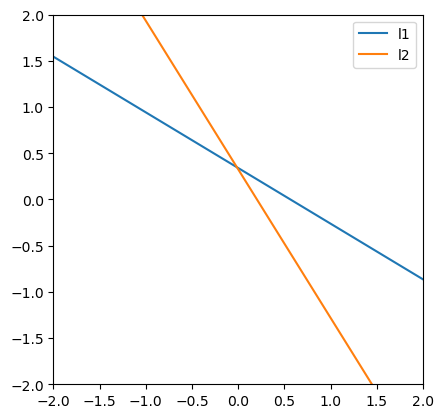

[   100]              nan ||   0.096496
[   200]              nan ||   0.093115
[   300]              nan ||   0.089852
[   400]              nan ||   0.086704
[   500]              nan ||   0.083666
[   600]              nan ||   0.080734
[   700]              nan ||   0.077906
[   800]              nan ||   0.075176
[   900]              nan ||   0.072542
[  1000]              nan ||   0.070000
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.0000000000
  eq-l_l1_l2_1                                       0.0000000000
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


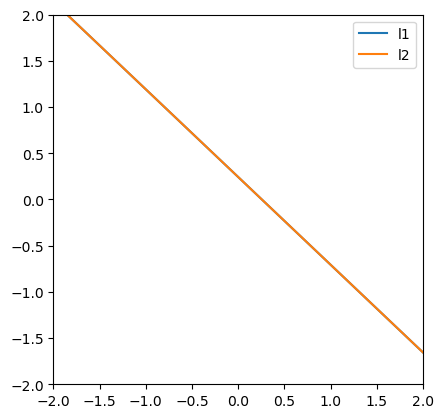

[  1100]              nan ||   0.067547
[  1200]              nan ||   0.065180
[  1300]              nan ||   0.062897
[  1400]              nan ||   0.060693
[  1500]              nan ||   0.058566
[  1600]              nan ||   0.056514
[  1700]              nan ||   0.054534
[  1800]              nan ||   0.052623
[  1900]              nan ||   0.050779
[  2000]              nan ||   0.049000
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.0000000000
  eq-l_l1_l2_1                                       0.0000000000
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


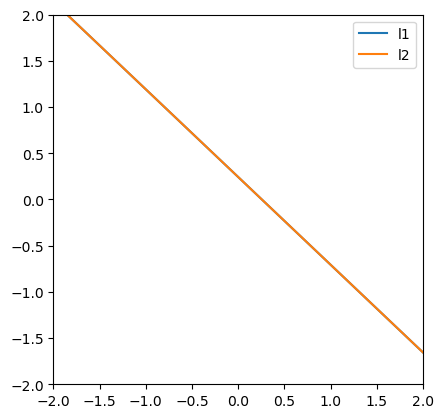

[  2100]              nan ||   0.047283
[  2200]              nan ||   0.045626
[  2300]              nan ||   0.044028
[  2400]              nan ||   0.042485
[  2500]              nan ||   0.040996
[  2600]              nan ||   0.039560
[  2700]              nan ||   0.038174
[  2800]              nan ||   0.036836
[  2900]              nan ||   0.035545
[  3000]              nan ||   0.034300
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.0000000000
  eq-l_l1_l2_1                                       0.0000000000
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


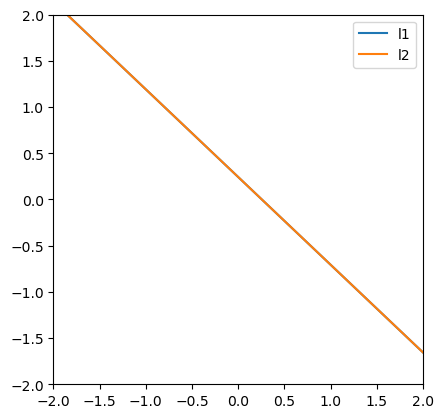

[  3100]              nan ||   0.033098
[  3200]              nan ||   0.031938
[  3300]              nan ||   0.030819
[  3400]              nan ||   0.029739
[  3500]              nan ||   0.028697
[  3600]              nan ||   0.027692
[  3700]              nan ||   0.026722
[  3800]              nan ||   0.025785
[  3900]              nan ||   0.024882
[  4000]              nan ||   0.024010
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.0000000000
  eq-l_l1_l2_1                                       0.0000000000
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


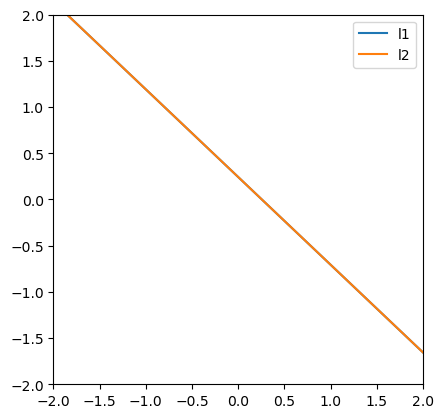

[  4100]              nan ||   0.023169
[  4200]              nan ||   0.022357
[  4300]              nan ||   0.021574
[  4400]              nan ||   0.020818
[  4500]              nan ||   0.020088
[  4600]              nan ||   0.019384
[  4700]              nan ||   0.018705
[  4800]              nan ||   0.018050
[  4900]              nan ||   0.017417
[     0]              nan ||   0.100000
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       1.2961058571
  eq-l_l1_l2_1                                       0.3961847348
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


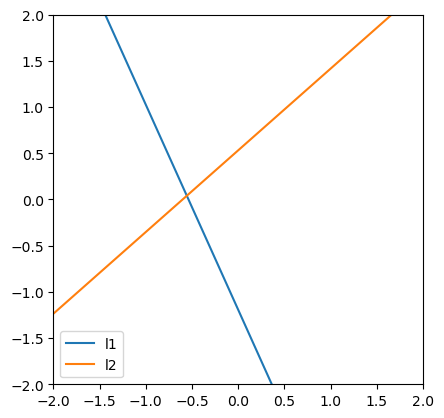

[   100]              nan ||   0.096496
[   200]              nan ||   0.093115
[   300]              nan ||   0.089852
[   400]              nan ||   0.086704
[   500]              nan ||   0.083666
[   600]              nan ||   0.080734
[   700]              nan ||   0.077906
[   800]              nan ||   0.075176
[   900]              nan ||   0.072542
[  1000]              nan ||   0.070000
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.0000000000
  eq-l_l1_l2_1                                       0.0000000000
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


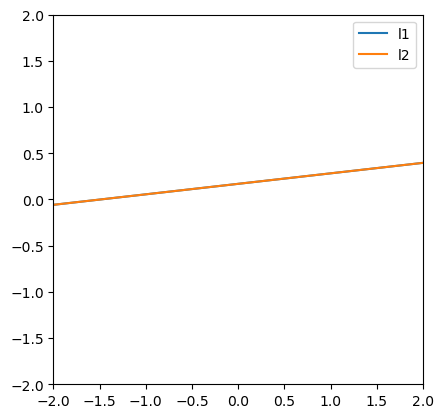

[  1100]              nan ||   0.067547
[  1200]              nan ||   0.065180
[  1300]              nan ||   0.062897
[  1400]              nan ||   0.060693
[  1500]              nan ||   0.058566
[  1600]              nan ||   0.056514
[  1700]              nan ||   0.054534
[  1800]              nan ||   0.052623
[  1900]              nan ||   0.050779
[  2000]              nan ||   0.049000
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.0000000000
  eq-l_l1_l2_1                                       0.0000000000
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


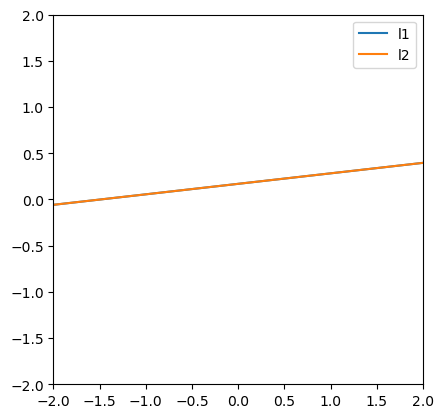

[  2100]              nan ||   0.047283
[  2200]              nan ||   0.045626
[  2300]              nan ||   0.044028
[  2400]              nan ||   0.042485
[  2500]              nan ||   0.040996
[  2600]              nan ||   0.039560
[  2700]              nan ||   0.038174
[  2800]              nan ||   0.036836
[  2900]              nan ||   0.035545
[  3000]              nan ||   0.034300
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.0000000000
  eq-l_l1_l2_1                                       0.0000000000
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


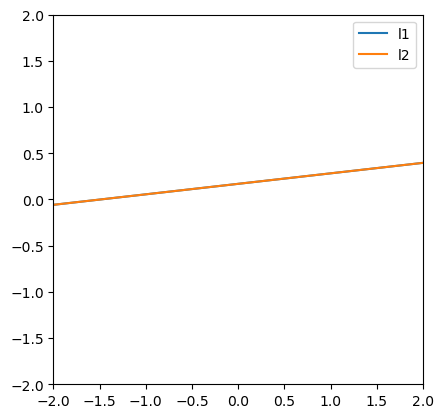

[  3100]              nan ||   0.033098
[  3200]              nan ||   0.031938
[  3300]              nan ||   0.030819
[  3400]              nan ||   0.029739
[  3500]              nan ||   0.028697
[  3600]              nan ||   0.027692
[  3700]              nan ||   0.026722
[  3800]              nan ||   0.025785
[  3900]              nan ||   0.024882
[  4000]              nan ||   0.024010
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.0000000000
  eq-l_l1_l2_1                                       0.0000000000
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


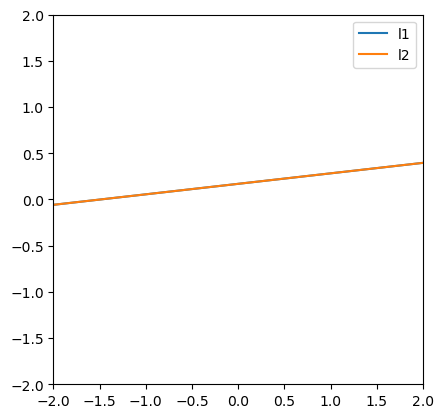

[  4100]              nan ||   0.023169
[  4200]              nan ||   0.022357
[  4300]              nan ||   0.021574
[  4400]              nan ||   0.020818
[  4500]              nan ||   0.020088
[  4600]              nan ||   0.019384
[  4700]              nan ||   0.018705
[  4800]              nan ||   0.018050
[  4900]              nan ||   0.017417
[     0]              nan ||   0.100000
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.7576363655
  eq-l_l1_l2_1                                       0.2170274817
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


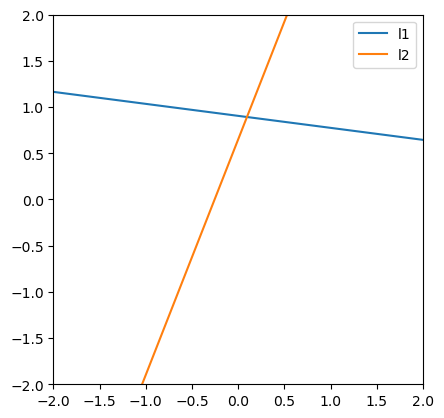

[   100]              nan ||   0.096496
[   200]              nan ||   0.093115
[   300]              nan ||   0.089852
[   400]              nan ||   0.086704
[   500]              nan ||   0.083666
[   600]              nan ||   0.080734
[   700]              nan ||   0.077906
[   800]              nan ||   0.075176
[   900]              nan ||   0.072542
[  1000]              nan ||   0.070000
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.0000000000
  eq-l_l1_l2_1                                       0.0000000000
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


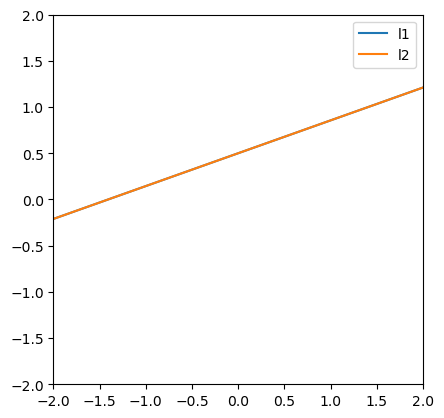

[  1100]              nan ||   0.067547
[  1200]              nan ||   0.065180
[  1300]              nan ||   0.062897
[  1400]              nan ||   0.060693
[  1500]              nan ||   0.058566
[  1600]              nan ||   0.056514
[  1700]              nan ||   0.054534
[  1800]              nan ||   0.052623
[  1900]              nan ||   0.050779
[  2000]              nan ||   0.049000
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.0000000000
  eq-l_l1_l2_1                                       0.0000000000
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


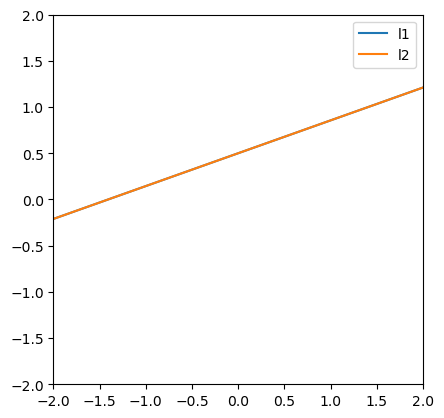

[  2100]              nan ||   0.047283
[  2200]              nan ||   0.045626
[  2300]              nan ||   0.044028
[  2400]              nan ||   0.042485
[  2500]              nan ||   0.040996
[  2600]              nan ||   0.039560
[  2700]              nan ||   0.038174
[  2800]              nan ||   0.036836
[  2900]              nan ||   0.035545
[  3000]              nan ||   0.034300
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.0000000000
  eq-l_l1_l2_1                                       0.0000000000
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


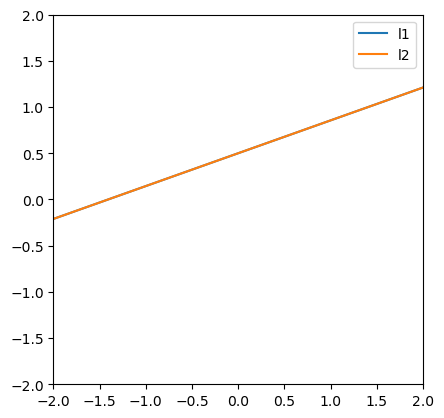

[  3100]              nan ||   0.033098
[  3200]              nan ||   0.031938
[  3300]              nan ||   0.030819
[  3400]              nan ||   0.029739
[  3500]              nan ||   0.028697
[  3600]              nan ||   0.027692
[  3700]              nan ||   0.026722
[  3800]              nan ||   0.025785
[  3900]              nan ||   0.024882
[  4000]              nan ||   0.024010
======== Print losses ==========
-- Losses --
  eq-l_l1_l2_0                                       0.0000000000
  eq-l_l1_l2_1                                       0.0000000000
  points                                             nan
  distinct                                           nan
-- Goals --
-- NDGs --


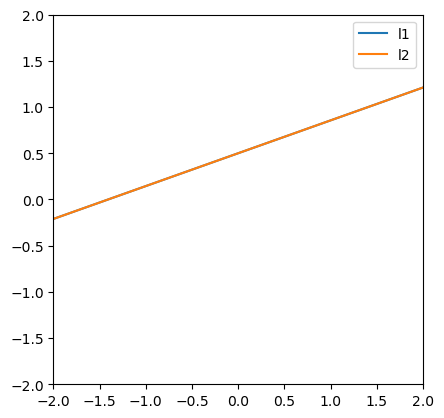

[  4100]              nan ||   0.023169
[  4200]              nan ||   0.022357
[  4300]              nan ||   0.021574
[  4400]              nan ||   0.020818
[  4500]              nan ||   0.020088
[  4600]              nan ||   0.019384
[  4700]              nan ||   0.018705
[  4800]              nan ||   0.018050
[  4900]              nan ||   0.017417


Found 0 models
['(param l1 line)', '(param l2 line)', '(assert (= l1 l2))']


In [424]:
num_steps = 0
aaa = generate_graph(num_steps, args, reader)

In [416]:
def read_GMBL_list(filename):
    with open(filename) as file:
        lines = [line.rstrip() for line in file]
    return lines

gmbl_dict = {}
file_list = os.listdir('gmbl_lang')
for filename in file_list:
    gmbl_dict[filename[: -4]] = read_GMBL_list('gmbl_lang/' + filename)

In [417]:
gmbl_dict

{'functions_circle': ['c3',
  'circumcircle',
  'excircle',
  'incircle',
  'mixtilinear-incircle',
  'diam'],
 'functions_line': ['line', 'isogonal', 'isotomic', 'perp-bis', 'perp-at'],
 'functions_number': ['add',
  'area',
  'dist',
  'div',
  'mul',
  'pi',
  'pow',
  'neg',
  'radius',
  'sqrt',
  'uangle'],
 'functions_point': ['amidp-opp',
  'amidp-same',
  'centroid',
  'circumcenter',
  'excenter',
  'foot',
  'harmonic-conj',
  'incenter',
  'inter-cc',
  'inter-ll',
  'inter-lc',
  'isogonal-conj',
  'isotomic-conj',
  'midp',
  'mixtilinear-incenter',
  'orthocenter'],
 'param': ['point',
  'line',
  'circle',
  'acute-tri',
  'acute-iso-tri',
  'iso-tri',
  'right-tri',
  'triangle',
  'polygon'],
 'parameterization_circle': ['tangent-cc',
  'tangent-cl',
  'through',
  'origin',
  'radius'],
 'parameterization_line': ['tangent-lc', 'through'],
 'parameterization_point': ['on-circ',
  'on-line',
  'on-major-arc',
  'on-minor-arc',
  'in-poly',
  'on-ray',
  'on-ray-opp',
 

In [418]:
random.sample(range(6), 1)[0] + 1

1

In [359]:
cnt = 1
rand_num = random.sample(range(5), 1)[0] + 3
obj_name = '('
for i in range(rand_num):
    obj_name += 'P' + str(cnt + i + 1) + ' '
obj_name = obj_name[: -1]
obj_name += ')'

print(rand_num, obj_name)

7 (P2 P3 P4 P5 P6 P7 P8)


In [382]:
random.sample(range(3), 4)

ValueError: Sample larger than population or is negative